# Review to Rating on Acne Product Review using Long Short-Therm Memory

## Import All Dependencies

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

np.random.seed(38)

from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import LSTM, Embedding, Dense, SpatialDropout1D, Input, Flatten, Dropout, Conv1D, Conv2D, Bidirectional, TimeDistributed
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

In [0]:
df = pd.read_excel('Dataset Acne Review.xlsx')
x, y = df['Review'].tolist(), df['Rating'].tolist()
y = [val-1 for val in y]
y = to_categorical(y, num_classes=5)

x = [data.lower() for data in x]
x = [(' '.join(data.split(','))) for data in x] # memisahkan koma
x = [(' '.join(data.split('?'))) for data in x] # memisahkan tanda tanya
x = [(' '.join(data.split('.'))) for data in x] # memisahkan titik
x = [(' '.join(data.split('!'))) for data in x] # memisahkan titik
x = [(' '.join(data.split('"'))) for data in x] # memisahkan titik
x = [(' '.join(data.split('-'))) for data in x] # memisahkan titik

x_train_text, x_test_text, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [0]:
print("Data-set size: ", len(x))
print("Train-set size: ", len(x_train_text))
print("Test-set size:  ", len(x_test_text))

Data-set size:  200
Train-set size:  150
Test-set size:   50


In [0]:
data_text = x_train_text + x_test_text

In [0]:
x_train_text[0], y_train[0]

('agak kurang cocok sama produk2 nya larissa  termasuk obat jerawat ini  ga bikin jerawat kempes  malah makin bertambah  kulit di sekitar yg dioles jadi kering  mungkin krn efek sulfurnya  udh mau abis 1 botol tp ga ada perubahan jd aku stop aja',
 array([0., 1., 0., 0., 0.], dtype=float32))

## Preprocessing

In [0]:
num_words = 1000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(x_train_text)
if num_words is None:
    num_words = len(tokenizer.word_index)

x_train_tokens = tokenizer.texts_to_sequences(x_train_text)
x_test_tokens = tokenizer.texts_to_sequences(x_test_text)

In [0]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

In [0]:
max_tokens = int(np.mean(num_tokens) + 2 * np.std(num_tokens))
max_tokens

89

In [0]:
pad = 'pre'
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,
                            padding=pad, truncating=pad)
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)

## Build Model

In [0]:
model = Sequential()
embedding_size = 32
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='layer_embedding'))
model.add(Bidirectional(LSTM(units=32, dropout=0.2, return_sequences=True, recurrent_dropout=0.2, activation='tanh')))
model.add(Bidirectional(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2, activation='tanh')))
model.add(Dense(16, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_embedding (Embedding)  (None, 89, 32)            32000     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 89, 64)            16640     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 85        
Total params: 74,597
Trainable params: 74,597
Non-trainable params: 0
_________________________________________________________________


## Training

In [0]:
history = model.fit(x_train_pad, y_train, validation_split=0.25, epochs=10)

Train on 112 samples, validate on 38 samples
Epoch 1/10
112/112 [==============================] - 4s 36ms/step - loss: 0.5007 - acc: 0.8000 - val_loss: 0.5004 - val_acc: 0.8000
Epoch 2/10
112/112 [==============================] - 0s 4ms/step - loss: 0.5001 - acc: 0.8000 - val_loss: 0.5004 - val_acc: 0.8000
Epoch 3/10
112/112 [==============================] - 0s 4ms/step - loss: 0.4997 - acc: 0.8000 - val_loss: 0.5003 - val_acc: 0.8000
Epoch 4/10
112/112 [==============================] - 0s 4ms/step - loss: 0.4987 - acc: 0.8000 - val_loss: 0.5005 - val_acc: 0.8000
Epoch 5/10
112/112 [==============================] - 0s 4ms/step - loss: 0.4985 - acc: 0.8000 - val_loss: 0.5006 - val_acc: 0.8000
Epoch 6/10
112/112 [==============================] - 0s 4ms/step - loss: 0.4964 - acc: 0.8000 - val_loss: 0.5006 - val_acc: 0.8000
Epoch 7/10
112/112 [==============================] - 1s 5ms/step - loss: 0.4953 - acc: 0.8000 - val_loss: 0.5004 - val_acc: 0.8000
Epoch 8/10
112/112 [==========

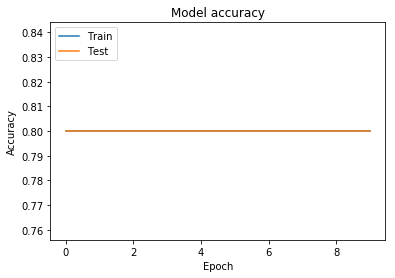

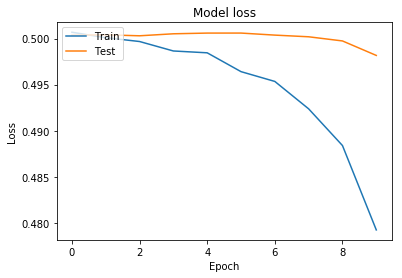

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Testing

In [0]:
result = model.evaluate(x_test_pad, y_test)
print("Accuracy: {0:.2%}".format(result[1]))

50/50 [==============================] - 0s 1ms/step
Accuracy: 80.00%


## Test on New Data

In [0]:
text_input = ['saya suka produk ini']
seq_input = tokenizer.texts_to_sequences(text_input)

x_input = pad_sequences(seq_input, maxlen=max_tokens,
                            padding=pad, truncating=pad)

np.argmax(model.predict(x_input)) + 1

5

In [0]:
text_input = ['niat hati pengen beli nourish yg lebih murah, tp di deket kosan adanya nexcare hehehe... di aku ini bagus sih. aku pakenya buat ke luar rumah gitu, soalnya kalo di rumah pake acne lotion erha. atau kadang kalo udah gengges, aku pakein juga pas tidur. dia bikin jerawatku yg baru muncul kempes, kalo jerawat ada matanya dia ngebantu buat matengin. gak sekali pake langsung ilang sih, biasanya semingguan gitu paling lama kalo aku. setelah pake ini biasanya bakalan nyisain bekas hitam makanya langsung lanjut ke treatment selanjutnya. tp so far suka sama ini, dan bakalan repurchase. sayangnya isinya dikit ya? kalo gak salah 12 ukuran kecil, 6 ukuran yg lebih besar. jd penasaran sama cosrx, kok rasa-rasanya lebih banyak isinya hehehe']
seq_input = tokenizer.texts_to_sequences(text_input)

x_input = pad_sequences(seq_input, maxlen=max_tokens,
                            padding=pad, truncating=pad)

np.argmax(model.predict(x_input)) + 1

5